In [109]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import pylab
import numpy as np
import copy,os,glob
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import seaborn as sns
% matplotlib inline

In [110]:
mesh = nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/mesh_files/mesh_mask_rm1Canada.nc')

In [111]:
mbathy = mesh.variables['mbathy'][0,600,300]
gdept = mesh.variables['gdept'][0,:mbathy,600,300]
gdepw = mesh.variables['gdepw'][0,:mbathy,600,300]
e3t = mesh.variables['e3t'][0,:mbathy,600,300]
e3w = mesh.variables['e3w'][0,:mbathy+1,600,300]

In [114]:
ice = nc.Dataset('/ocean/xiaoxiny/research/data/forcing/Ice_nt/ANHA4-ENG3_icemod_y2003m09.nc')
ice = ice.variables['ileadfra'][600,300]
print (ice)
ice = 0.9

xd = nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_diss.nc')
xd = xd.variables['Th_diss'][0,:mbathy,600,300]

xp = nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_part.nc')
xp = xp.variables['Th_part'][0,:mbathy,600,300]

0.96


In [115]:
gdept[17]

47.373688

In [120]:
# time info
dt  =  1./365/24/3600*10800
t  =  0.0
tmax  =  200  #run for 200 years

In [121]:
# initialize tracer profiles
xd_ = np.copy(xd)
xp_ = np.copy(xp)

anew = np.zeros(xd.shape)
bnew = np.zeros(xd.shape)
cnew = np.zeros(xd.shape)

In [116]:
# initialize the baseshape, with maximum shows up at around 50m

baseshape = np.zeros(gdept.shape)
# for the first 17 layers (the first 47.37m), function increases from 0.5 to 1
baseshape[0:18] = np.linspace(0.5,1,18)  
# decreases from 1 to 0.5 for deeper layers
baseshape[18:]  = np.linspace(1,0.5,len(gdept)-18)

In [118]:
S  =  np.zeros(gdept.shape)
k_ad  =  np.zeros(gdept.shape)

Q  =  0.0267 
#desorption constants
k_de  =  0.5     
                 
#sinking rate/adsorption constants
S[:]  =  (-1435*ice+1921)  
k_ad[:]  =  (-0.14*ice+0.24)*baseshape[:]

#### Assume k varies through depth (but s is constant)

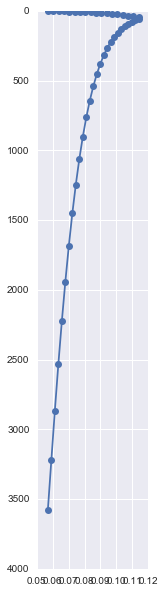

In [119]:
# plot the shape of k
fig = plt.figure(figsize = [2,10])
plt.plot(k_ad,gdept,'-o')
plt.gca().invert_yaxis()

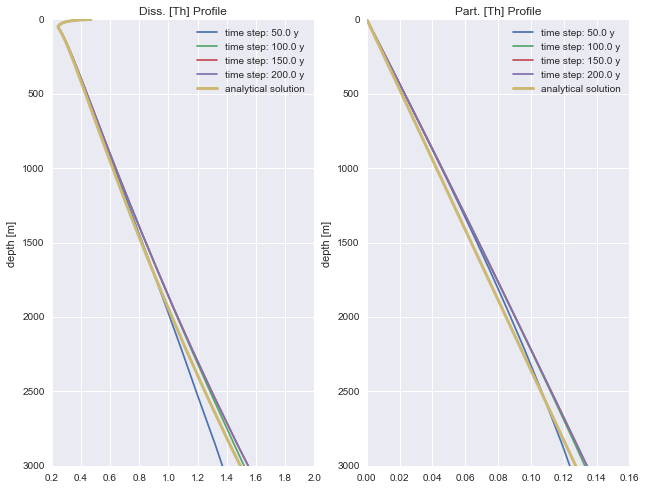

In [107]:
n = 0;pylab.figure(2, figsize  =  (16, 8));sns.set_style("darkgrid")

while (t < tmax):               
    # the surface BC.
    i = 0                         
    anew[i]  =  xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt
    bnew[i]  =  0
    
    # loop through the other depths
    i + =  1
    while (i < =  mbathy-1):    
        
        # forward difference
        anew[i]  =  xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt

        bnew[i]  =  xp_[i] + ((S[i-1]*xp_[i-1]-S[i]*xp_[i])/e3t[i] 
                  + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
        
        i + =  1

    # store the updated solution
    xd_[:]  =  anew[:]
    xp_[:]  =  bnew[:]

    t + =  dt

    n + =  1
    if n%(2920*50) =  = 0:

        # plot dissolved and particulate every 50 years
        pylab.subplot(131)
        pylab.plot(xd_, gdept,label =  'time step: %s y'%(n/2920))
        pylab.subplot(132)
        pylab.plot(xp_, gdept,label =  'time step: %s y'%(n/2920))

    
# calculate analytical solution
x = gdept
yp = Q/S*x
yd = Q/k_ad[:]+k_de/k_ad[:]*yp    
    
# label and scale plots
pylab.figure(2, figsize  =  (16, 8))
pylab.subplot(131)
pylab.ylabel('depth [m]')
pylab.title('Diss. [Th] Profile')
pylab.plot(yd,x,lw = 3,label = 'analytical solution')
pylab.ylim(0,3000)
plt.legend(loc = 0)
pylab.gca().invert_yaxis()

pylab.subplot(132)
pylab.ylabel('depth [m]')
pylab.title('Part. [Th] Profile')
pylab.plot(yp,x,lw = 3,label = 'analytical solution')
pylab.ylim(0,3000)
plt.legend(loc = 0)
pylab.gca().invert_yaxis()



#### Assume both s and k change with depth.

In [122]:
S[:]  =  (-1435*ice+1921)*baseshape[:] 

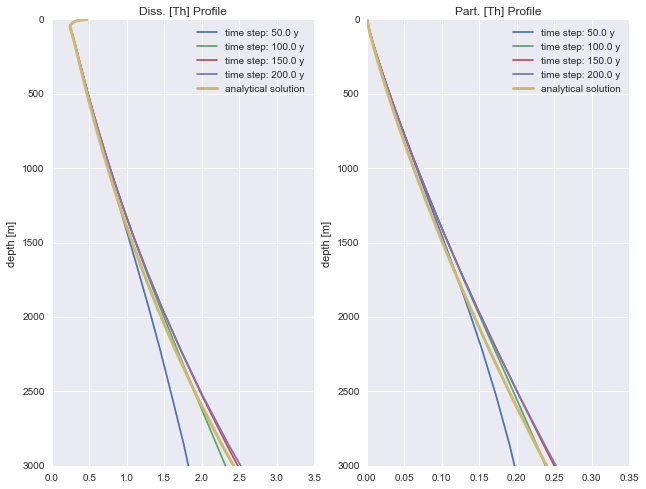

In [123]:
n = 0;pylab.figure(2, figsize  =  (16, 8));sns.set_style("darkgrid")

while (t < tmax):  

    # the surface BC.
    i = 0                         
    anew[i]  =  xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt
    bnew[i]  =  0

    # loop through other depths
    i + =  1
    while (i < =  mbathy-1):    
        
        # forward difference
        anew[i]  =  xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt

        bnew[i]  =  xp_[i] + ((S[i-1]*xp_[i-1]-S[i]*xp_[i])/e3t[i] 
                  + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
        
        i + =  1

    # store the updated solution
    xd_[:]  =  anew[:]
    xp_[:]  =  bnew[:]

    t + =  dt

    n + =  1
    if n%(2920*50) =  = 0:

        # plot dissolved and particulate every 50 years
        pylab.subplot(131)
        pylab.plot(xd_, gdept,label =  'time step: %s y'%(n/2920))
        pylab.subplot(132)
        pylab.plot(xp_, gdept,label =  'time step: %s y'%(n/2920))


    
# calculate analytical solution
x = gdept
yp = Q/S*x
yd = Q/k_ad[:]+k_de/k_ad[:]*yp    
    
# label and scale plots
pylab.figure(2, figsize  =  (16, 8))
pylab.subplot(131)
pylab.ylabel('depth [m]')
pylab.title('Diss. [Th] Profile')
pylab.plot(yd,x,lw = 3,label = 'analytical solution')
pylab.ylim(0,3000)
plt.legend(loc = 0)

pylab.gca().invert_yaxis()

pylab.subplot(132)
pylab.ylabel('depth [m]')
pylab.title('Part. [Th] Profile')
pylab.plot(yp,x,lw = 3,label = 'analytical solution')
pylab.ylim(0,3000)
plt.legend(loc = 0)
pylab.gca().invert_yaxis()

